## Overview
This notebook loads a pre-trained model that converts a sketch or photo to a Chinese landscape painting. 

- Sketch to painting
    1. Use several post-processing steps to convert the sketch into a sketch-like edge map.
    2. Use the model to predict a painting based on the sketch-like edge map
- Photo to painting (style transfer)
    1. Convert the photo into a HED edge map
    2. Use several post-processing steps to convert the HED edge map into a sketch-like edge map
    3. Use the model to predict a painting based on the sketch-like edge map 

**Dependencies:**
Before you start, first upload
1. `hed.py`, and
2. `HED_pretrained_bsds.npz`
to `GDRIVE_PATH`

References
1. Holistically Nested Edge Detection(HED)
    - [paper](https://arxiv.org/abs/1504.06375) 
    - [pre-trained model](https://github.com/tensorpack/tensorpack/tree/master/examples/HED)  
2. Edge map post-processing - [SketchyGAN](https://arxiv.org/abs/1801.02753) (Section 3.3)

## Set Up

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
GDRIVE_PATH = 'gdrive/MyDrive/ColabNotebooks/CSC2515_Project/Part2/sketch2paint/' # Replace with your own
PATH = '/root/.keras/'

In [3]:
pip install -q tensorpack

     |████████████████████████████████| 296kB 14.6MB/s 


In [4]:
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt

import numpy as np
from scipy import ndimage
import cv2
import glob
from PIL import Image
from skimage import morphology
import math

In [5]:
tf.random.set_seed(1234)

In [6]:
mkdir generated_paintings

## Helper Functions

In [7]:
IMG_WIDTH = 512
IMG_HEIGHT = 512

In [8]:
def to_jpg(im_path):
  im_name = im_path.split('/')[-1]
  suffix = im_name.split('.')[-1]
  prefix = im_name.split('.')[0]
  if(suffix == 'jpg'):
    return

  image = cv2.imread(im_path)
  cv2.imwrite('photos/{}.jpg'.format(prefix), image, [int(cv2.IMWRITE_JPEG_QUALITY), 100])

def resize(input_image, height, width):
  return cv2.resize(input_image, (height, width), interpolation = cv2.INTER_AREA)

# normalizing the images to [-1, 1]
def normalize(input_image):
  return (input_image / 127.5) - 1

In [9]:
def generate_painting(model, test_input, orig_sketch, out_path, sketchname):
  prediction = model(test_input, training=True)
  fig = plt.figure(figsize=(30,30))
  
  display_list = [orig_sketch, test_input[0], prediction[0]]
  title = ['Original Image', 'Processed Sketch', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()
  fig.savefig('{}/{}'.format(out_path, sketchname), bbox_inches='tight')


def edgemap_to_painting_predict(path_processed, path_orig, path_out):
  sketch_paths = glob.iglob(path_processed + '*.jpg', recursive=True)
  for sketch_path in sketch_paths:
    sketchname = sketch_path.split('/')[-1]
    print(sketchname)
    orig_sketch_path = path_orig + sketchname

    sketch = Image.open(sketch_path).convert('RGB')
    sketch = np.asarray(sketch, dtype=np.float32)
    sketch = tf.constant(sketch)
    sketch = normalize(sketch)
    sketch = tf.expand_dims(sketch, 0)

    sketch_orig = Image.open(orig_sketch_path).convert('RGB')
    sketch_orig = normalize(np.asarray(sketch_orig, dtype=np.float32))

    generate_painting(generator, sketch, sketch_orig, path_out, sketchname)

## Load model

In [10]:
URLs = [
        'https://github.com/Luxi-Zhao/sketch-to-Chinese-landscape-painting-data/raw/master/models/pix2pix_512_400e_sketch2paint/modelaa',
        'https://github.com/Luxi-Zhao/sketch-to-Chinese-landscape-painting-data/raw/master/models/pix2pix_512_400e_sketch2paint/modelab',
        'https://github.com/Luxi-Zhao/sketch-to-Chinese-landscape-painting-data/raw/master/models/pix2pix_512_400e_sketch2paint/modelac',
        'https://github.com/Luxi-Zhao/sketch-to-Chinese-landscape-painting-data/raw/master/models/pix2pix_512_400e_sketch2paint/modelad',
        'https://github.com/Luxi-Zhao/sketch-to-Chinese-landscape-painting-data/raw/master/models/pix2pix_512_400e_sketch2paint/modelae',
] 

# Get the model
for i in range(len(URLs)):
  url = URLs[i]
  zip_name = url.split('/')[-1]
  tf.keras.utils.get_file(zip_name,
                          origin=url,
                          extract=False,
                          cache_subdir='/content/')

38969344/38963257 [==============================] - 0s 0us/step


In [11]:
cat model* > modelcomb.tar.gz

In [12]:
!tar -zxvf modelcomb.tar.gz

pix2pix_model512_400_sketch2paint/
pix2pix_model512_400_sketch2paint/saved_model.pb
pix2pix_model512_400_sketch2paint/assets/
pix2pix_model512_400_sketch2paint/variables/
pix2pix_model512_400_sketch2paint/variables/variables.index
pix2pix_model512_400_sketch2paint/variables/variables.data-00000-of-00001


In [13]:
generator = tf.saved_model.load('pix2pix_model512_400_sketch2paint')

## Generate Paintings from Human Sketches

In [14]:
mkdir human_sketches

Upload some 512x512 sketches to the above directory. An example sketch is shown below.

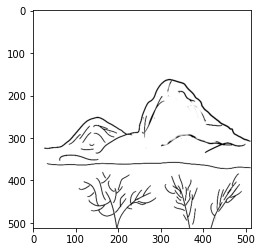

In [32]:
img = cv2.imread('human_sketches/Sketch10.jpg', 0)
img = np.asarray(img) / 255
plt.imshow(img, cmap='gray')
plt.show()

In [15]:
mkdir human_sketches_processed

In [16]:
def post_process_human_sketch(img):
  img = cv2.adaptiveThreshold(img, 255 ,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 0)
  img = np.asarray(img, np.float32) / 255

  thinned = morphology.thin(img)
  cleaned = morphology.remove_small_objects(thinned, min_size=16, connectivity=2)
  return cleaned

def post_process_human_sketches(in_path, out_path):
  files = glob.iglob(in_path, recursive=True)
  for f in files:
    img = cv2.imread(f, 0)
    img = 255 - img
    img = post_process_human_sketch(img)

    image_name = f.split('/')[-1]
    image_name = image_name.split('.')[0]
    cv2.imwrite('{}/{}.jpg'.format(out_path, image_name), img * 255)

Sketch2.jpg


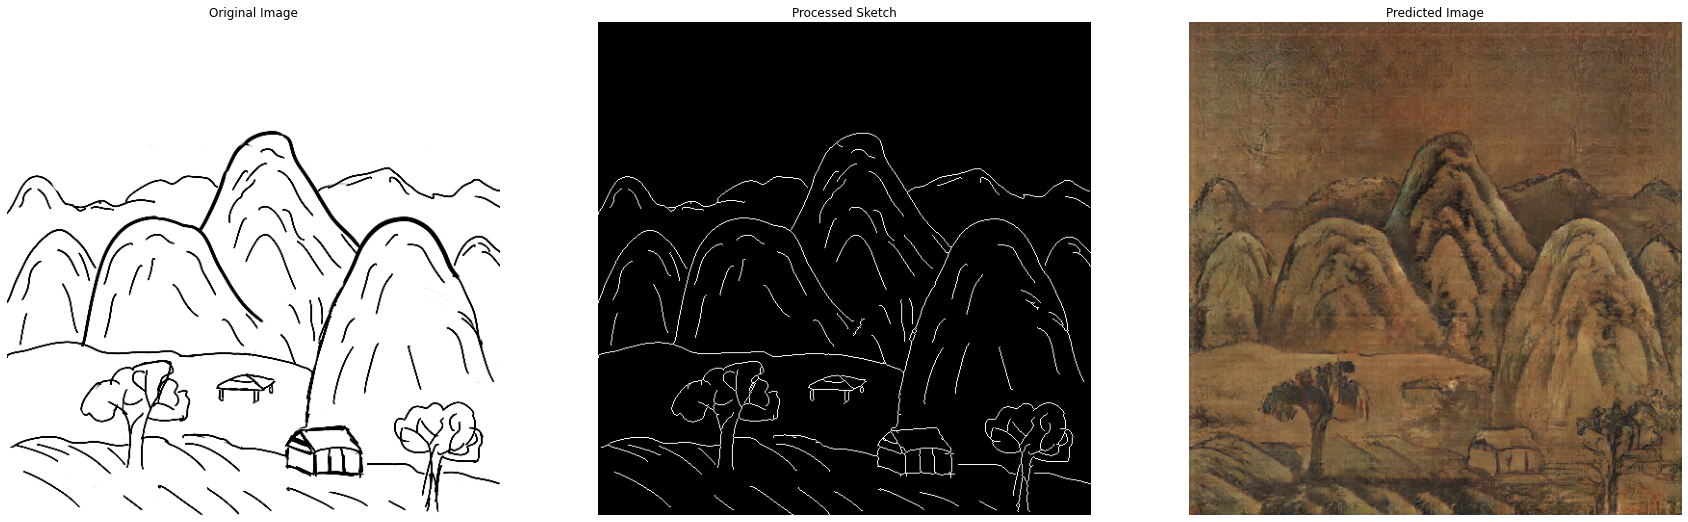

Sketch8.jpg


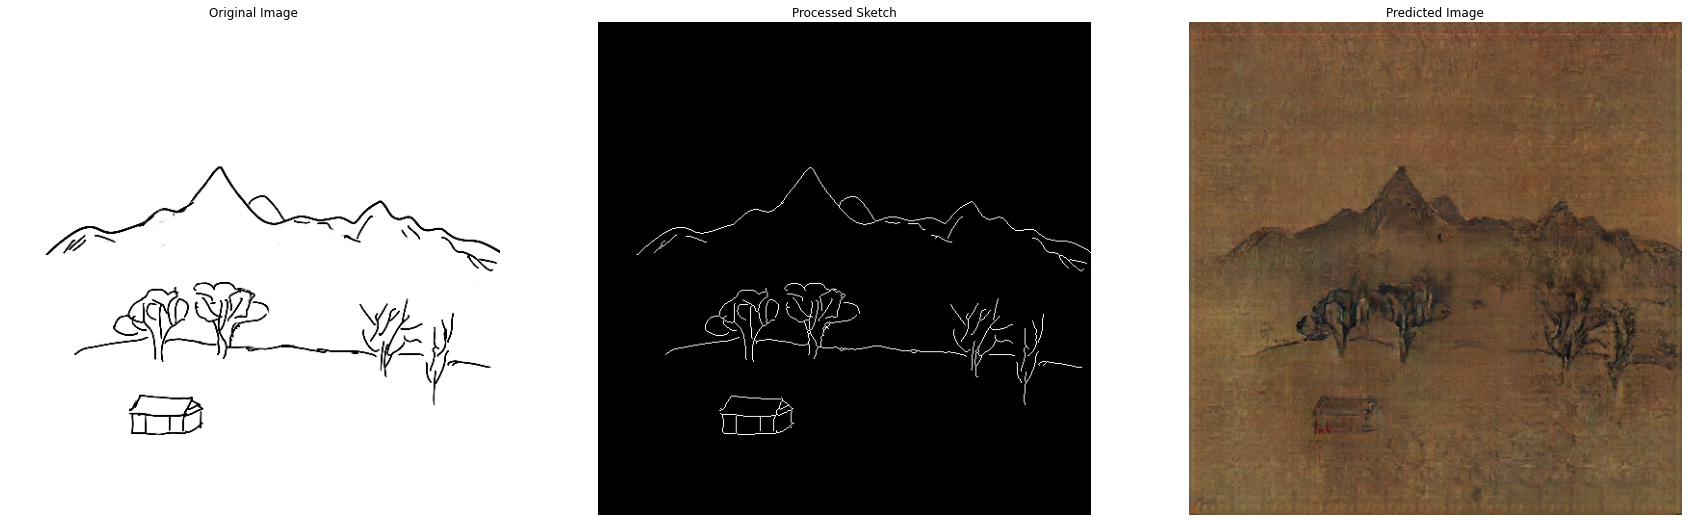

Sketch4.jpg


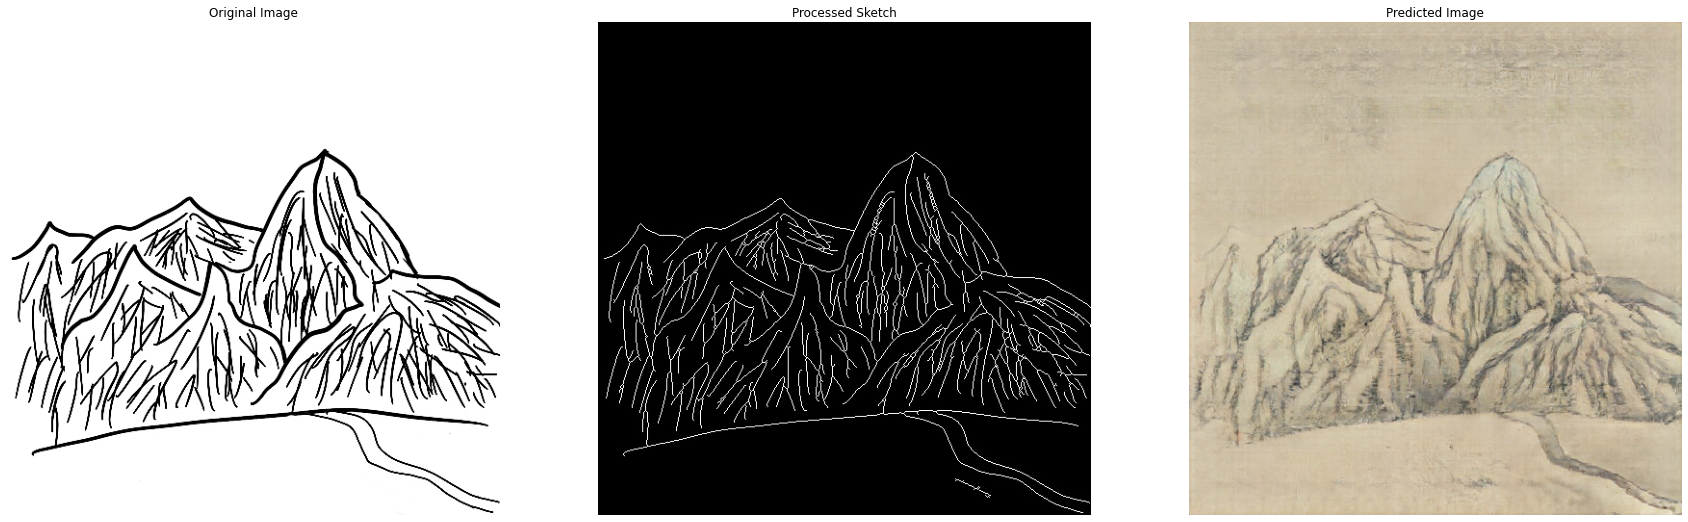

In [17]:
post_process_human_sketches('human_sketches/*.jpg', 'human_sketches_processed')
edgemap_to_painting_predict('human_sketches_processed/', 'human_sketches/', 'generated_paintings')

## Generate Paintings from Photos

In [18]:
mkdir photos

Upload some images to `photos`.

In [19]:
files = glob.iglob('photos/*', recursive=True)
for f in files:
  to_jpg(f)

In [20]:
mkdir hed

### Generate HED Edge Maps

In [21]:
!python {GDRIVE_PATH}hed.py --load {GDRIVE_PATH}HED_pretrained_bsds.npz --inpath "photos/*.jpg" --outpath hed

2020-12-28 20:56:45.422117: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
[1228 20:56:47 @sessinit.py:294] Loading dictionary from gdrive/MyDrive/ColabNotebooks/CSC2515_Project/Part2/hedcode/HED_pretrained_bsds.npz ...
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
[1228 20:56:49 @registry.py:90] 'conv1_1': [?, 3, ?, ?] --> [?, 64, ?, ?]
[1228 20:56:49 @registry.py:90] 'conv1_2': [?, 64, ?, ?] --> [?, 64, ?, ?]
[1228 20:56:49 @registry.py:90] 'branch1/convfc': [?, 64, ?, ?] --> [?, 1, ?, ?]
[1228 20:56:49 @registry.py:90] 'pool1': [?, 64, ?, ?] --> [?, 64, ?, ?]
[1228 20:56:49 @registry.py:90] 'conv2_1': [?, 64, ?, ?] --> [?, 128, ?, ?]
[1228 20:56:49 @registry.py:90] 'conv2_2': [?, 128, ?, ?] --

In [22]:
files = glob.iglob('hed/*.jpg', recursive=True)
for f in files:
  filename = f.split('/')[-1]
  prefix_arr = filename.split('_')
  prefix = '_'.join(prefix_arr[:-1])
  outpath = 'hed/{}.jpg'.format(prefix)
  os.rename(f, outpath)

### Post-Process HED Edge Maps
This step aims to convert a painting's edge map into a form that resembles a human-drawn sketch. To achieve this, each HED edge map is binarized, thinned, and cleaned.

In [23]:
'''
Returns a binarized image containing boolean values [True, False]
'''
def post_process_img(img):
  img = resize(img, IMG_HEIGHT, IMG_WIDTH)
  img = cv2.adaptiveThreshold(img, 255 ,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 0)
  img = np.asarray(img, dtype=np.float32) / 255

  thinned = morphology.thin(img)
  cleaned = morphology.remove_small_objects(thinned, min_size=128, connectivity=2)
  return cleaned

In [24]:
def post_process_all(in_path, out_path):
  files = glob.iglob(in_path, recursive=True)
  for f in files:
    img = cv2.imread(f, 0)
    img = post_process_img(img)

    image_name = f.split('/')[-1]
    image_name = image_name.split('.')[0]
    cv2.imwrite('{}/{}.jpg'.format(out_path, image_name), img * 255)

In [25]:
mkdir hed_processed

In [26]:
post_process_all('hed/*', 'hed_processed')

### Apply Style Transfer

mountain2.jpg


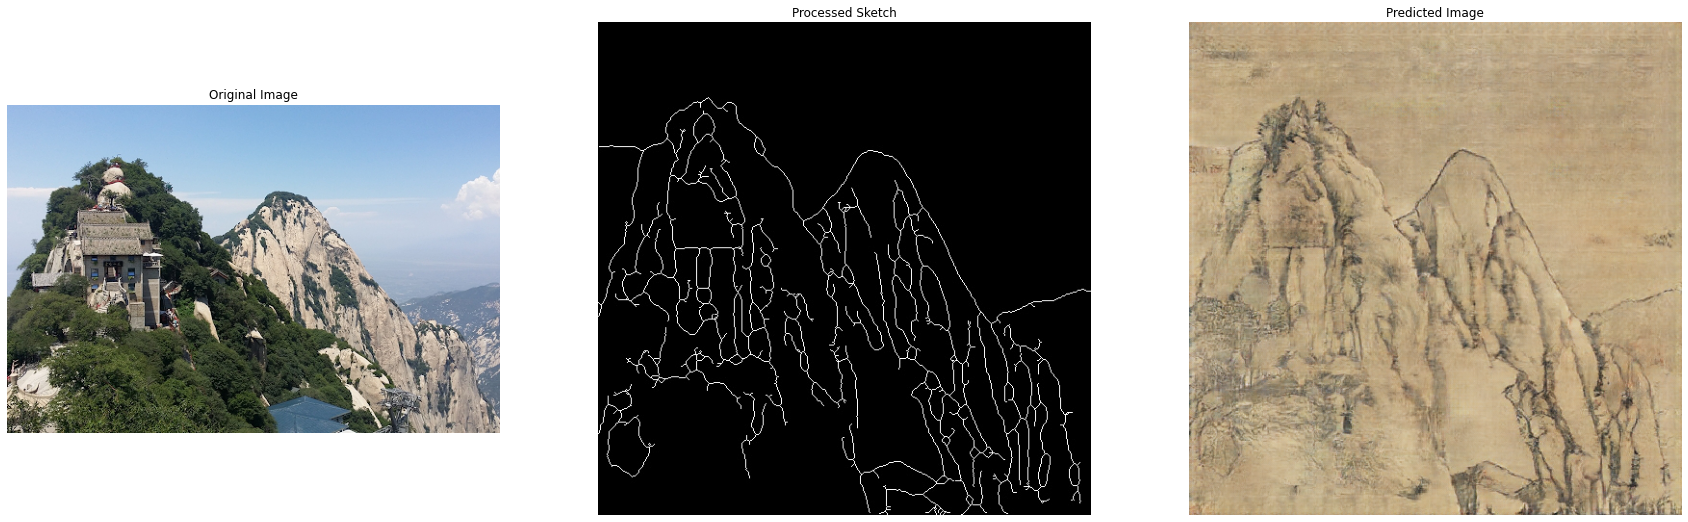

mountain.jpg


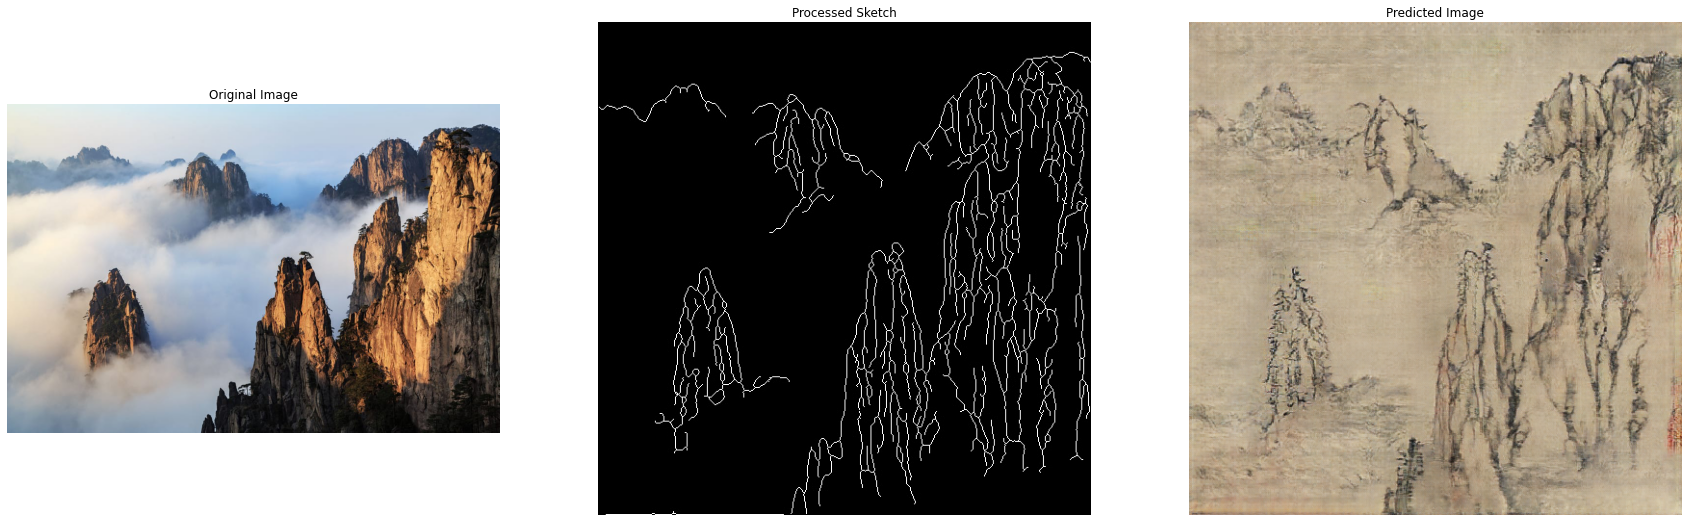

In [27]:
edgemap_to_painting_predict('hed_processed/', 'photos/', 'generated_paintings')